In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

2025-11-17 10:30:11.701184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763375411.876829      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763375411.932655      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32


In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/potato-disease-prediction/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    
    
    
    
)

Found 2151 files belonging to 3 classes.


I0000 00:00:1763375427.607938      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
cla=dataset.class_names

In [5]:

class_name=[i  for i in dataset.class_names if i.split("_")[0]=='Potato']

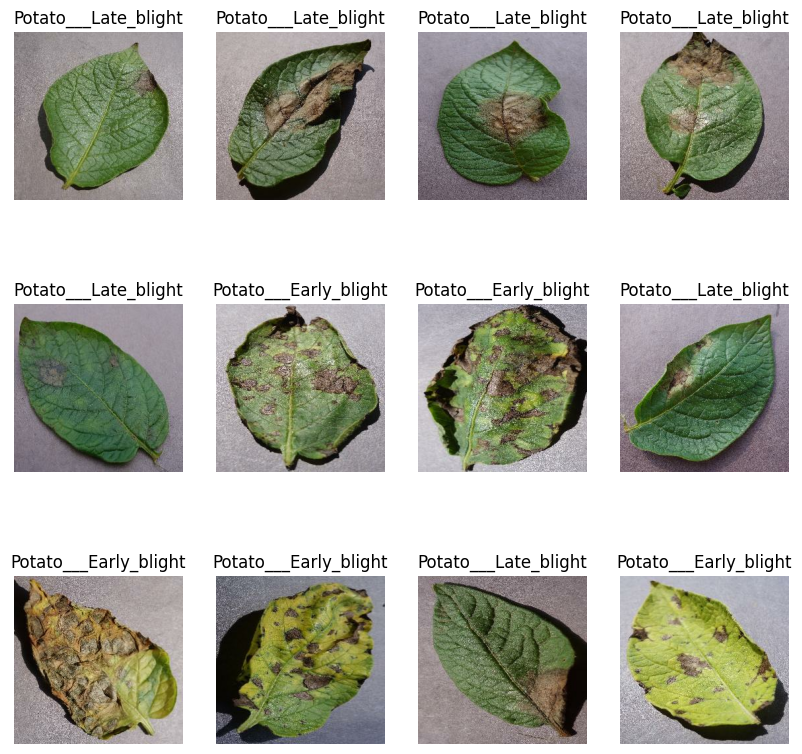

In [6]:
plt.figure(figsize=(10,10))
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(cla[label_batch[i]])
        plt.axis("off")
    
    

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds 

In [15]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [16]:
len(test_ds)

8

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    
])

In [20]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history=model.fit(train_ds,epochs=50,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50


I0000 00:00:1763375442.383568     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.4181 - loss: 0.9834 - val_accuracy: 0.4740 - val_loss: 0.8783
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5085 - loss: 0.8734 - val_accuracy: 0.6771 - val_loss: 0.7169
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7044 - loss: 0.6610 - val_accuracy: 0.8385 - val_loss: 0.4531
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8161 - loss: 0.4530 - val_accuracy: 0.8438 - val_loss: 0.3380
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8529 - loss: 0.3494 - val_accuracy: 0.9115 - val_loss: 0.2618
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8969 - loss: 0.2693 - val_accuracy: 0.9323 - val_loss: 0.2270
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9091 - loss: 0.2593 - val_accuracy: 0.8854 - val_loss: 0.2475
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9345 - loss: 0.1786 - val_accuracy: 0.9167 - val_loss: 

In [24]:
score=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9454 - loss: 0.1900


In [25]:
score

[0.15718089044094086, 0.9453125]

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

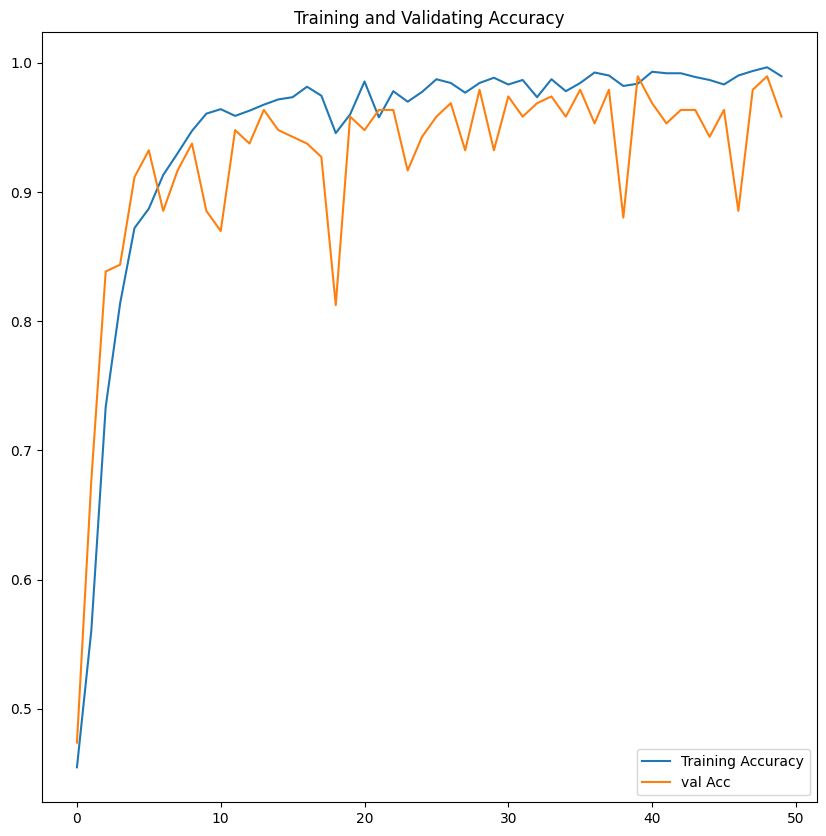

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.plot(range(50),acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='val Acc')
plt.legend(loc='lower right')
plt.title('Training and Validating Accuracy')
plt.show()

Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Potato___healthy


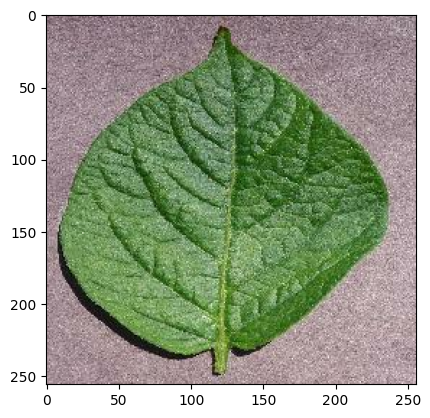

In [28]:
for images_batch,labels_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    plt.imshow(first_img)
    print(cla[first_label])

    batch_prediction=model.predict(images_batch)
    print(cla[np.argmax(batch_prediction[0])])

In [29]:
model.save("/kaggle/working/model.h5")